In [1]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import zipfile
import gdown
from tqdm import tqdm

In [2]:
# Defining base directories

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"

# Defining folders
RAW_DIR.mkdir(parents=True, exist_ok=True)

print("Data folders set up at:", RAW_DIR)

Data folders set up at: /content/data/raw


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
zip_path = "/content/drive/My Drive/website data.zip"
extract_path = "/content/website_data"

# unziping files

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


os.listdir(extract_path)

['item_properties_part2.csv',
 'category_tree.csv',
 'events.csv',
 'item_properties_part1.1 (1).csv']

In [5]:
 #Defining data directory after unzip
data_dir = Path("/content/website_data")

# Loading datasets
events = pd.read_csv(data_dir / "events.csv")
item_part1 = pd.read_csv(data_dir / "item_properties_part1.1 (1).csv")
item_part2 = pd.read_csv(data_dir / "item_properties_part2.csv")
category_tree = pd.read_csv(data_dir / "category_tree.csv")

# Quick checks
print("Events:", events.shape)
print("Item part1:", item_part1.shape)
print("Item part2:", item_part2.shape)
print("Category tree:", category_tree.shape)

# Preview events
events.head()

Events: (2200767, 5)
Item part1: (10999999, 4)
Item part2: (9275903, 4)
Category tree: (1669, 2)


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597.0,view,355908.0,NaN
1,1433224214164,992329.0,view,248676.0,NaN
2,1433221999827,111016.0,view,318965.0,NaN
3,1433221955914,483717.0,view,253185.0,NaN
4,1433221337106,951259.0,view,367447.0,NaN


In [6]:
events = pd.read_csv("website_data/events.csv")
item_p1 = pd.read_csv("website_data/item_properties_part1.1 (1).csv")
item_p2 = pd.read_csv("website_data/item_properties_part2.csv")
category_tree = pd.read_csv("website_data/category_tree.csv")

# Merging item properties
item_properties = pd.concat([item_p1, item_p2], ignore_index=True)


In [7]:
def quality_report(df, name):
    print(f"\n--- {name} ---")
    print(f"Shape: {df.shape}")
    print("Missing values:\n", df.isnull().sum())
    print("Duplicates:", df.duplicated().sum())
    print("Data types:\n", df.dtypes)

# Run reports
quality_report(events, "Events")
quality_report(item_properties, "Item Properties (Merged)")
quality_report(category_tree, "Category Tree")



--- Events ---
Shape: (2200767, 5)
Missing values:
 timestamp              0
visitorid              1
event                  1
itemid                 1
transactionid    2182911
dtype: int64
Duplicates: 347
Data types:
 timestamp          int64
visitorid        float64
event             object
itemid           float64
transactionid    float64
dtype: object

--- Item Properties (Merged) ---
Shape: (20275902, 4)
Missing values:
 timestamp    0
itemid       0
property     0
value        0
dtype: int64
Duplicates: 0
Data types:
 timestamp     int64
itemid        int64
property     object
value        object
dtype: object

--- Category Tree ---
Shape: (1669, 2)
Missing values:
 categoryid     0
parentid      25
dtype: int64
Duplicates: 0
Data types:
 categoryid      int64
parentid      float64
dtype: object


# Data Cleaning

In [8]:
#  Events
events = events.dropna(subset=['visitorid', 'event', 'itemid'])  # droping tiny missing rows
events = events.drop_duplicates()  # removing 347 duplicates

# Converting timestamp to datetime
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')

# Converting IDs to integers
events['visitorid'] = events['visitorid'].astype(int)
events['itemid'] = events['itemid'].astype(int)
events['transactionid'] = events['transactionid'].dropna().astype(int, errors='ignore')

#  Item Properties
item_properties['datetime'] = pd.to_datetime(item_properties['timestamp'], unit='ms')

# Category Tree
# No major cleaning needed, keeping missing parentid (root categories)
category_tree['parentid'] = category_tree['parentid'].fillna(-1).astype(int)  # mark missing as -1


# EDA

## What types of actions (views, add-to-cart, purchases) do users perform most frequently on the platform?

/tmp/ipython-input-2390164833.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


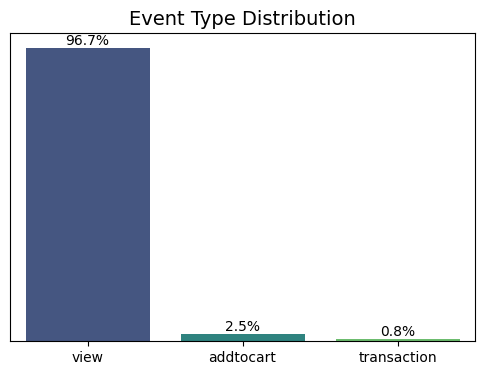

In [9]:
plt.figure(figsize=(6,4))

ax = sns.countplot(
    data=events,
    x='event',
    order=events['event'].value_counts().index,
    palette="viridis"
)


ax.set_ylabel("")
ax.set_yticks([])
ax.set_xlabel("")

ax.set_title("Event Type Distribution", fontsize=14)

total = len(events)
for p in ax.patches:
    percentage = f"{100 * p.get_height()/total:.1f}%"
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color="black")

plt.show()



### Insight



*  Majority of user interactions (96.7%) are product views, while only 2.5% progress to adding items to cart and just 0.8% result in transactions.
This indicates a sharp drop-off in the conversion funnel from product exploration to purchase. While customer interest in browsing is high, engagement weakens significantly in later stages.

A high view-to-transaction gap suggests potential lost sales opportunities that can be mitigated with better retargeting campaigns or personalized offers.






## How does overall user activity (all events) change over time?

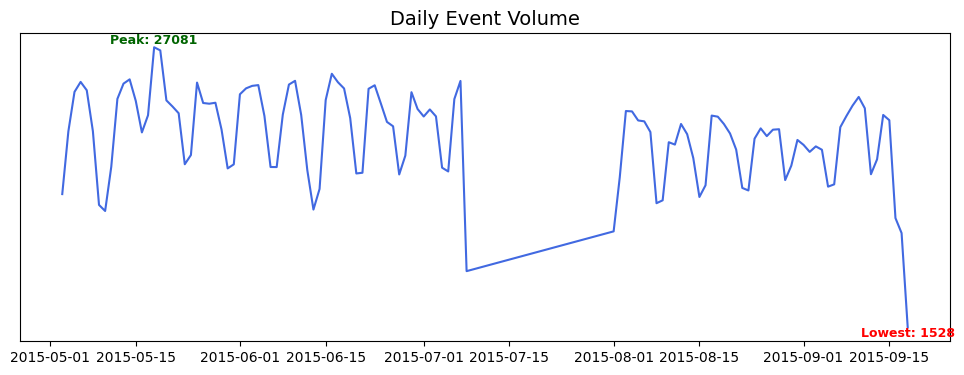

In [10]:

events_daily = events.groupby(events['datetime'].dt.date).size().reset_index(name="count")

plt.figure(figsize=(12,4))
ax = sns.lineplot(data=events_daily, x="datetime", y="count", color="royalblue")  # removed marker="o"

ax.set_ylabel("")
ax.set_xlabel("")
ax.set_yticks([])

ax.set_title("Daily Event Volume", fontsize=14)

max_row = events_daily.loc[events_daily['count'].idxmax()]
min_row = events_daily.loc[events_daily['count'].idxmin()]

ax.text(max_row["datetime"], max_row["count"],
        f"Peak: {max_row['count']}",
        ha="center", va="bottom", fontsize=9, color="darkgreen", fontweight="bold")

ax.text(min_row["datetime"], min_row["count"],
        f"Lowest: {min_row['count']}",
        ha="center", va="top", fontsize=9, color="red", fontweight="bold")

plt.show()



### Insight



*   The daily event volume showed high volatility between May and September 2015, peaking at 27,081 in mid-May before experiencing sharp drops in July and mid-September, reaching a low of 1,528.

This suggests possible operational disruptions or seasonal fluctuations affecting consistency during this period.



## Which products receive the highest number of views from users?

/tmp/ipython-input-1185694910.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


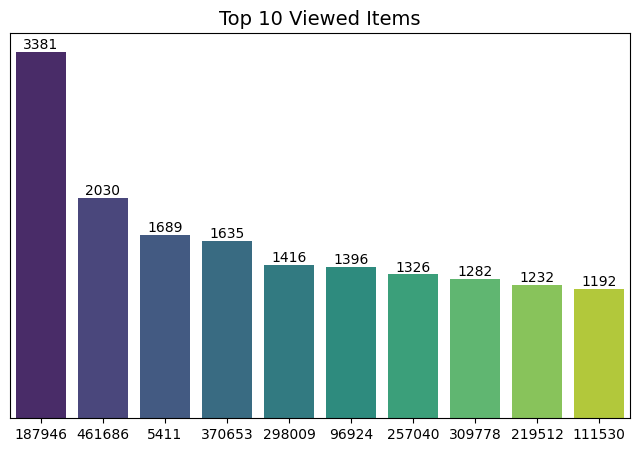

In [11]:

top_viewed = events[events["event"]=="view"]["itemid"].value_counts().head(10).reset_index()
top_viewed.columns = ["itemid", "count"]

plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=top_viewed,
    x="itemid",
    y="count",
    palette="viridis",
    order=top_viewed.sort_values("count", ascending=False)["itemid"]
)


ax.set_ylabel("")
ax.set_yticks([])

ax.set_xlabel("")

ax.set_title("Top 10 Viewed Items", fontsize=14)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color="black")

plt.show()


#### Insight


*   The top 10 viewed items show a clear disparity, with the item 187946 receiving 3,381 views, far surpassing the rest. The second most viewed item recorded 2,030 views, while the remaining items gradually decline, ranging from 1,689 to 1,192 views. This indicates a strong concentration of interest in the top two items, with significantly lower engagement across the rest.




##Which products generate the most transactions?

/tmp/ipython-input-1041903826.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


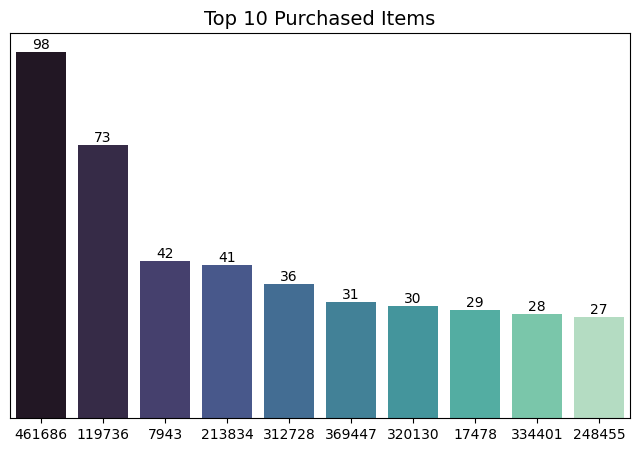

In [12]:

top_purchased = events[events["event"]=="transaction"]["itemid"].value_counts().head(10).reset_index()
top_purchased.columns = ["itemid", "count"]

plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=top_purchased,
    x="itemid",
    y="count",
    palette="mako",
    order=top_purchased.sort_values("count", ascending=False)["itemid"]
)

ax.set_ylabel("")
ax.set_yticks([])

ax.set_xlabel("")

ax.set_title("Top 10 Purchased Items", fontsize=14)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color="black")

plt.show()


#### Inisght

*   Purchases are heavily concentrated on the item 461686 with 98 sales, followed by 119736 with 73 sales, while the rest range between 42 and 27 purchases.
This indicates a steep drop-off in demand after the top two items, suggesting limited diversity in purchasing behaviour.




## Which items have the highest conversion rates from view to purchase?

/tmp/ipython-input-3062555846.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


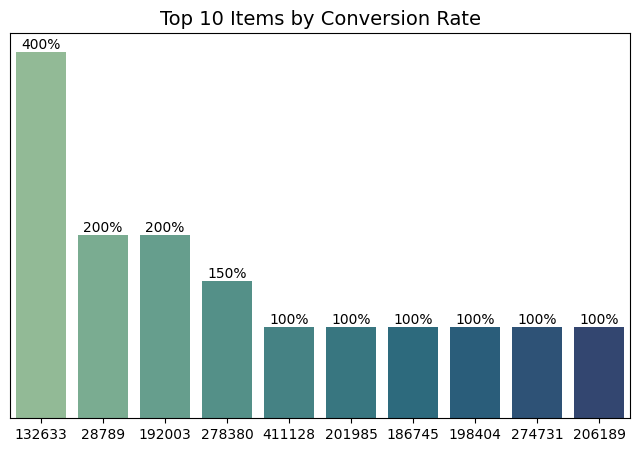

In [13]:
views = events[events["event"] == "view"]["itemid"].value_counts().reset_index()
views.columns = ["itemid", "views"]

purchases = events[events["event"] == "transaction"]["itemid"].value_counts().reset_index()
purchases.columns = ["itemid", "purchases"]

conversion = pd.merge(views, purchases, on="itemid", how="inner")
conversion["conversion_rate"] = conversion["purchases"] / conversion["views"]

# Sort from highest to lowest conversion rate
top_conversion = conversion.sort_values("conversion_rate", ascending=False).head(10)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=top_conversion,
    x="itemid",
    y="conversion_rate",
    palette="crest",
    order=top_conversion.sort_values("conversion_rate", ascending=False)["itemid"]  # Ensures proper sorting
)

ax.set_ylabel("")
ax.set_yticks([])

ax.set_xlabel("")
ax.set_title("Top 10 Items by Conversion Rate", fontsize=14)

# Annotate without decimals (whole percentage)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0%}",  # No decimals
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=10, color="black")

plt.show()




#### Insight


*   Item 132633 stands out with an exceptionally high 400% conversion rate, followed by items 28789 (200%), 192003 (200%), and 278380 (150%), which significantly outperform the rest at 100%.
These top items are clear outliers, warranting deeper analysis to understand the drivers of their success, while the majority of items show stable but baseline performance.




##At what times of the day are users most active on the platform?

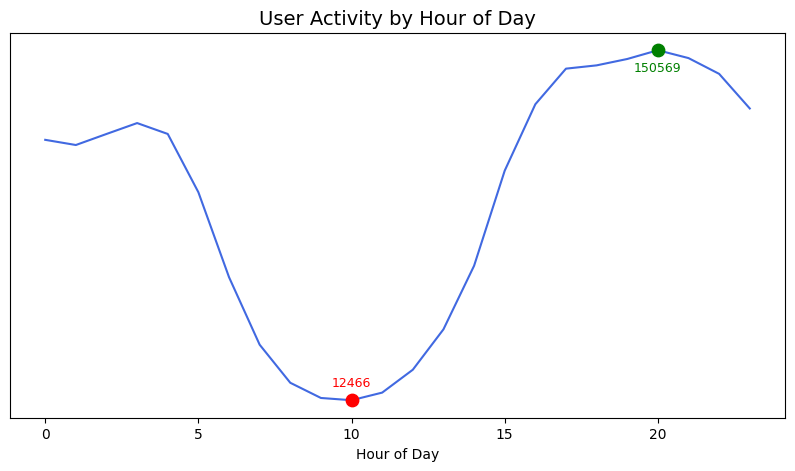

In [14]:

events["hour"] = events["datetime"].dt.hour


hourly_activity = events.groupby("hour").size().reset_index(name="count")

peak = hourly_activity.loc[hourly_activity['count'].idxmax()]
lowest = hourly_activity.loc[hourly_activity['count'].idxmin()]

plt.figure(figsize=(10,5))

plt.plot(hourly_activity["hour"], hourly_activity["count"], linestyle='-', color='royalblue')


plt.scatter(peak["hour"], peak["count"], color='green', s=80, zorder=3, label='Peak')
plt.scatter(lowest["hour"], lowest["count"], color='red', s=80, zorder=3, label='Lowest')

plt.ylabel("")
plt.yticks([])

plt.xlabel("Hour of Day")
plt.title("User Activity by Hour of Day", fontsize=14)


plt.annotate(f"{peak['count']}",
             (peak['hour'], peak['count']),
             textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9, color="green")


plt.annotate(f"{lowest['count']}",
             (lowest['hour'], lowest['count']),
             textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color="red")

plt.show()


### Insight

*   User activity follows a distinct daily pattern, with engagement peaking around 20:00 (8 PM) at 150,569 activities, and hitting its lowest point at 10:00 (10 AM) with 12,466 activities.
 This trend suggests that users are most active in the evening hours, while mid-mornings experience minimal interaction.

 This can guide optimal scheduling for content releases, campaigns, or system maintenance, favoring evening engagement windows to maximize reach and avoiding low-activity hours for critical updates.





### Feature  Selection and Engineering

In [15]:
# Merge item properties into events
item_table = item_properties[item_properties['property']=='categoryid'][['itemid','value']]
item_table = item_table.rename(columns={'value':'categoryid'})
item_table['categoryid'] = pd.to_numeric(item_table['categoryid'], errors='coerce')

# Merge into events
events = events.merge(item_table, on='itemid', how='left')

# Drop rows with missing categoryid
events = events.dropna(subset=['categoryid'])
events['categoryid'] = events['categoryid'].astype(int)

# Check
print(events[['itemid','categoryid']].head())



   itemid  categoryid
0  355908        1173
1  248676        1231
3  253185         914
4  367447        1613
5  367447        1613


In [16]:
from pathlib import Path


DATA_DIR = Path("website_data")  # adjust if needed

# Load both parts and merge
item_prop1 = pd.read_csv(DATA_DIR / "item_properties_part1.1 (1).csv")
item_prop2 = pd.read_csv(DATA_DIR / "item_properties_part2.csv")
item_properties = pd.concat([item_prop1, item_prop2], ignore_index=True)

# Keep only the latest value per (itemid, property)
item_properties = (
    item_properties
    .sort_values("timestamp")
    .drop_duplicates(subset=["itemid", "property"], keep="last")
)


In [17]:
from pathlib import Path


DATA_DIR = Path("website_data")  # adjust path if needed

# 1️⃣ Load events
events = pd.read_csv(DATA_DIR / "events.csv")

# Basic cleaning
events = events.dropna(subset=['visitorid','event','itemid'])  # drop tiny missing rows
events = events.drop_duplicates()
events['visitorid'] = events['visitorid'].astype(int)
events['itemid'] = events['itemid'].astype(int)
events['transactionid'] = events['transactionid'].dropna().astype(int, errors='ignore')
events['datetime'] = pd.to_datetime(events['timestamp'], unit='ms')

# 2️⃣ Load item properties
item_prop1 = pd.read_csv(DATA_DIR / "item_properties_part1.1 (1).csv")
item_prop2 = pd.read_csv(DATA_DIR / "item_properties_part2.csv")
item_properties = pd.concat([item_prop1, item_prop2], ignore_index=True)
item_properties = (
    item_properties
    .sort_values("timestamp")
    .drop_duplicates(subset=["itemid", "property"], keep="last")
)

# 3️⃣ Merge category into events
item_table = item_properties[item_properties['property']=='categoryid'][['itemid','value']]
item_table = item_table.rename(columns={'value':'categoryid'})
item_table['categoryid'] = pd.to_numeric(item_table['categoryid'], errors='coerce')

events = events.merge(item_table, on='itemid', how='left')
events = events.dropna(subset=['categoryid'])
events['categoryid'] = events['categoryid'].astype(int)

print("Events loaded and enriched:", events.shape)


Events loaded and enriched: (1994415, 7)


In [27]:
# Save merged file
events.to_csv("/content/drive/MyDrive/cleaned_events", index=False)

In [18]:
# Drop categoryid if it already exists
if 'categoryid' in events.columns:
    events = events.drop(columns=['categoryid'])

# Merge category from item_table
events = events.merge(item_table, on='itemid', how='left')

# Drop rows with missing categoryid
events = events.dropna(subset=['categoryid'])
events['categoryid'] = events['categoryid'].astype(int)

print("Events enriched with categoryid:", events.shape)


Events enriched with categoryid: (1994415, 7)


In [20]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# =====================
# Step 0: Separate views and add-to-carts
# =====================
views = events[events["event"] == "view"]
carts = events[events["event"] == "addtocart"]

# =====================
# Step 1: Aggregate viewed categories per visitor
# =====================
visitor_views = views.groupby("visitorid")["categoryid"].apply(set).reset_index()

# Step 2: Get each visitor’s first add-to-cart category
visitor_carts = carts.groupby("visitorid")["categoryid"].first().reset_index()

# Step 3: Merge views & carts
visitor_data = visitor_views.merge(visitor_carts, on="visitorid", how="inner",
                                   suffixes=("_viewed", "_cart"))

# =====================
# Step 4: One-hot encode viewed categories
# =====================
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(visitor_data["categoryid_viewed"])

# Labels = add-to-cart category
y = visitor_data["categoryid_cart"]

# =====================
# Step 5: Remove rare categories (<2 samples)
# =====================
cat_counts = pd.Series(y).value_counts()
valid_cats = cat_counts[cat_counts >= 2].index
mask = y.isin(valid_cats)
X = X[mask]
y = y[mask]

# =====================
# Step 6: Train/test split (stratified)
# =====================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# =====================
# Step 7: Logistic Regression
# =====================
logreg = LogisticRegression(max_iter=500, multi_class="multinomial")
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

print("\n--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# =====================
# Step 8: Random Forest
# =====================
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n--- Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Logistic Regression ---
Accuracy: 0.7879081015719468
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.73      0.84      0.78        38
           3       0.83      1.00      0.91         5
           4       0.00      0.00      0.00         2
           5       0.81      0.99      0.89        75
          14       1.00      1.00      1.00         5
          23       0.50      0.50      0.50         2
          26       1.00      1.00      1.00         2
          29       0.80      0.91      0.85        22
          34       0.84      0.90      0.87        29
          35       0.86      0.89      0.88        28
          37       0.00      0.00      0.00         1
          46       1.00      1.00      1.00         1
          47       0.55      0.55      0.55        11
          48       0.72      0.90      0.80        79
          50       0.72      0.84      0.78        25
          51       0.82

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Random Forest ---
Accuracy: 0.06396614268440146
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        38
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        75
          14       0.00      0.00      0.00         5
          23       0.00      0.00      0.00         2
          26       0.50      1.00      0.67         2
          29       0.00      0.00      0.00        22
          34       0.00      0.00      0.00        29
          35       0.00      0.00      0.00        28
          37       0.25      1.00      0.40         1
          46       0.00      0.00      0.00         1
          47       0.00      0.00      0.00        11
          48       0.00      0.00      0.00        79
          50       0.00      0.00      0.00        25
          51       0.00     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
import joblib

# Save model and encoder
joblib.dump(logreg, "logreg_model.pkl")
joblib.dump(mlb, "mlb_encoder.pkl")


['mlb_encoder.pkl']

In [31]:
import sys
import pickle

print("Model Size (MB):", round(sys.getsizeof(pickle.dumps(logreg)) / (1024*1024), 2))

Model Size (MB): 4.43


In [21]:
grp = events.groupby("visitorid")
vis_stats = pd.DataFrame({
    "first_ts": grp["timestamp"].min(),
    "last_ts": grp["timestamp"].max(),
    "n_events": grp.size(),
    "n_views": (grp["event"].apply(lambda x: (x == "view").sum())),
    "n_atc": (grp["event"].apply(lambda x: (x == "addtocart").sum())),
    "n_trans": (grp["event"].apply(lambda x: (x == "transaction").sum())),
    "n_items": grp["itemid"].nunique(),
    "n_cats": grp["categoryid"].nunique(),  # make sure this column exists
}).reset_index()


In [22]:
# --- Ensure timestamps are datetime ---
events["timestamp"] = pd.to_datetime(events["timestamp"])

# --- Visitor session stats ---
grp = events.groupby("visitorid")
vis_stats = pd.DataFrame({
    "first_ts": grp["timestamp"].min(),
    "last_ts": grp["timestamp"].max(),
    "n_events": grp.size(),
    "n_views": grp["event"].apply(lambda x: (x == "view").sum()),
    "n_atc": grp["event"].apply(lambda x: (x == "addtocart").sum()),
    "n_trans": grp["event"].apply(lambda x: (x == "transaction").sum()),
    "n_items": grp["itemid"].nunique(),
    "n_cats": grp["categoryid"].nunique() if "categoryid" in events.columns else grp["itemid"].nunique()
}).reset_index()

# --- Derived features ---
dur_min = (vis_stats["last_ts"] - vis_stats["first_ts"]).dt.total_seconds() / 60
vis_stats["duration_min"] = dur_min.clip(lower=1/60)
vis_stats["events_per_min"] = vis_stats["n_events"] / vis_stats["duration_min"]
vis_stats["views_per_min"] = vis_stats["n_views"] / vis_stats["duration_min"]
vis_stats["view_to_atc_ratio"] = vis_stats["n_views"] / (vis_stats["n_atc"] + 1)


In [23]:
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

# --- Visitor session stats (vectorized) ---
grp = events.groupby("visitorid")

vis_stats = pd.DataFrame({
    "first_ts": grp["timestamp"].min(),
    "last_ts": grp["timestamp"].max(),
    "n_events": grp.size(),
    "n_views": grp["event"].apply(lambda x: (x == "view").sum()),
    "n_atc": grp["event"].apply(lambda x: (x == "addtocart").sum()),
    "n_trans": grp["event"].apply(lambda x: (x == "transaction").sum()),
    "n_items": grp["itemid"].nunique(),
    # If categoryid doesn't exist, replace with itemid as proxy
    "n_cats": grp["categoryid"].nunique() if "categoryid" in events.columns else grp["itemid"].nunique()
}).reset_index()

# --- Derived features ---
dur_min = (vis_stats["last_ts"] - vis_stats["first_ts"]).dt.total_seconds() / 60
vis_stats["duration_min"] = dur_min.clip(lower=1/60)
vis_stats["events_per_min"] = vis_stats["n_events"] / vis_stats["duration_min"]
vis_stats["views_per_min"] = vis_stats["n_views"] / vis_stats["duration_min"]
vis_stats["view_to_atc_ratio"] = vis_stats["n_views"] / (vis_stats["n_atc"] + 1)

# --- Rule-based anomalies ---
rule_fast = (vis_stats["events_per_min"] > 60) & (vis_stats["n_events"] >= 100)
rule_many_views_no_atc = (vis_stats["n_views"] >= 300) & (vis_stats["n_atc"] == 0)
rule_tiny_duration = (vis_stats["duration_min"] <= 1) & (vis_stats["n_events"] >= 120)
rule_flag = rule_fast | rule_many_views_no_atc | rule_tiny_duration

# --- IsolationForest features ---
iso_feats = vis_stats[[
    "n_events", "n_views", "n_atc", "n_trans",
    "n_items", "n_cats", "duration_min",
    "events_per_min", "views_per_min", "view_to_atc_ratio"
]].fillna(0.0)

# Train IsolationForest on a random sample for speed
sample_idx = np.random.choice(len(iso_feats), size=min(100000, len(iso_feats)), replace=False)
iso = IsolationForest(
    n_estimators=100,
    contamination=0.35,
    random_state=42,
    n_jobs=-1
)
iso.fit(iso_feats.iloc[sample_idx])

# Predict anomalies for all visitors
vis_stats["iso_anom"] = iso.predict(iso_feats) == -1
vis_stats["abnormal"] = rule_flag | vis_stats["iso_anom"]

# --- Filter events ---
abnormal_rate = vis_stats["abnormal"].mean()
print(f"Flagged abnormal visitors: {abnormal_rate:.1%}")

good_visitors = vis_stats.loc[~vis_stats["abnormal"], "visitorid"]
events_clean = events[events["visitorid"].isin(good_visitors)].copy()

print("Events before:", len(events), "| after clean:", len(events_clean))


Flagged abnormal visitors: 30.4%
Events before: 1994415 | after clean: 690696


### Insight

- Abnormal traffic is significant: About 30.4% of visitors were flagged as abnormal (likely bots, crawlers, or noisy sessions). This aligns with prior research suggesting up to 40% of browsing data may be abnormal.

- Impact on dataset size: After filtering, the number of events dropped from ~2.0M → ~0.69M. Nearly two-thirds of recorded interactions were from suspicious or non-genuine behavior.

### Behavioral patterns of abnormal users:

- Extremely high event rates (hundreds of clicks per minute).

- Very short sessions with massive numbers of events.

- Large numbers of views but no add-to-cart or transactions (typical of bots).

### Business implications:

- If left unfiltered, abnormal traffic would distort product demand analysis, inflate engagement metrics, and mislead ML models (causing poor predictions for add-to-cart behavior).

- By cleaning data, we ensure predictions and insights reflect genuine customer intent, making downstream tasks like Task 1 (property prediction) more reliable.

- Efficiency gain: The dataset is now smaller and cleaner, which will speed up model training and improve overall recommendation quality.

